# Finding the best method for differentiating your data

With the number of methods in this repo, it is fair to wonder which will work best on your noisy data. We have implemented a routine to run `optimize` over (almost) all PyNumDiff differentiation methods and let you know which method and parameters settings achieved the lowest cost.

Cost is either

1. RMSE against the true derivative if given or
2. $L$ if no true derivative is known.

> $L$ balances the faithfulness and smoothness of the derivative estimate:
> $$L = \text{RMSE} \bigg( \text{trapz}(\mathbf{\hat{\dot{x}}}(\Phi)) + \mu, \mathbf{y} \bigg) + \gamma \bigg({TV}\big(\mathbf{\hat{\dot{x}}}(\Phi)\big)\bigg)$$
> where $\mathbf{y}$ are the noisy measurements, $\mathbf{\hat{\dot{x}}}$ is the estimate of the derivative, $\text{trapz}(\cdot)$ is the discrete-time trapezoidal numerical integral, $\mu$ resolves the unknown integration constant, $\gamma$ is a hyper-parameter, and $TV$ is the total variation,
> $$TV(\mathbf{\hat{\dot{x}}}) = \frac{1}{m}\left\lVert\mathbf{\hat{\dot{x}}}_{0:m-1}-\mathbf{\hat{\dot{x}}}_{1:m}\right\rVert_{1}$$
> A reasonable value of $\gamma$ can be estimated given a cutoff frequency (estimated by counting peaks per second in the data or by looking at power spectrum and choosing a cutoff), $f$, as
> $$\gamma = \exp(-1.6 \log(f) -0.71\log(\Delta t) - 5.1)$$
> See [this paper](https://ieeexplore.ieee.org/document/9241009) for more detail.

In [1]:
import os, sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path) # local import

from pynumdiff.optimize import suggest_method
from pynumdiff.utils import evaluate
from pynumdiff.utils.simulate import sine, triangle, pop_dyn, linear_autonomous,\
	pi_control, lorenz_x

## Simulate some data

In [2]:
# noise is generated using np.random, e.g. np.random.normal, np.random.uniform, np.random.poisson
# noise_type and noise_parameters should be compatible with np.random functions 
noise_type = 'normal'
noise_parameters = [0, 0.1]

# time step and time series length
dt = 0.01 # sampling time step
duration = 4 # sec
problem = pi_control

x, x_truth, dxdt_truth, extras = problem(duration, 
                                        noise_parameters=noise_parameters, 
                                        dt=dt)

## Usage of the best method metamethod with known truth

In [3]:
method, opt_params = suggest_method(x, dt, dxdt_truth=dxdt_truth)

100%|██████████| 18/18 [02:43<00:00,  9.09s/it]


Best method: spectraldiff with params: {'even_extension': np.True_, 'pad_to_zero_dxdt': np.True_, 'high_freq_cutoff': np.float64(0.04185185185185189)}
RMS error in velocity:  0.6247026237512912


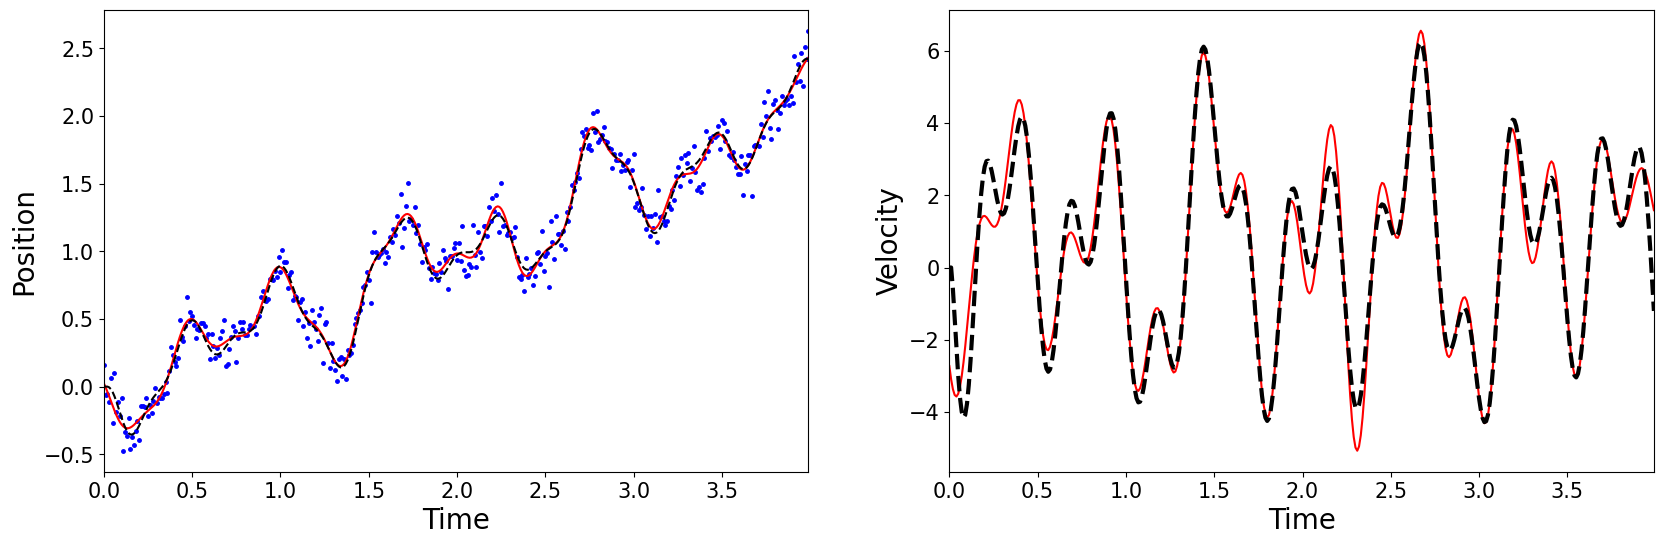

In [4]:
print('Best method:', method.__name__, 'with params:', opt_params)
x_hat, dxdt_hat = method(x, dt, **opt_params)
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth)

## Usage of the best method metamethod *without* known truth

In [3]:
method, opt_params = suggest_method(x, dt, cutoff_frequency=3)

  0%|          | 0/17 [00:00<?, ?it/s]

100%|██████████| 17/17 [02:28<00:00,  8.73s/it]


Best method: constant_velocity with params: {'forwardbackward': np.True_, 'q': np.float64(0.030000000000000082), 'r': np.float64(0.00013999999999999983)}
RMS error in velocity:  0.8281469620658048


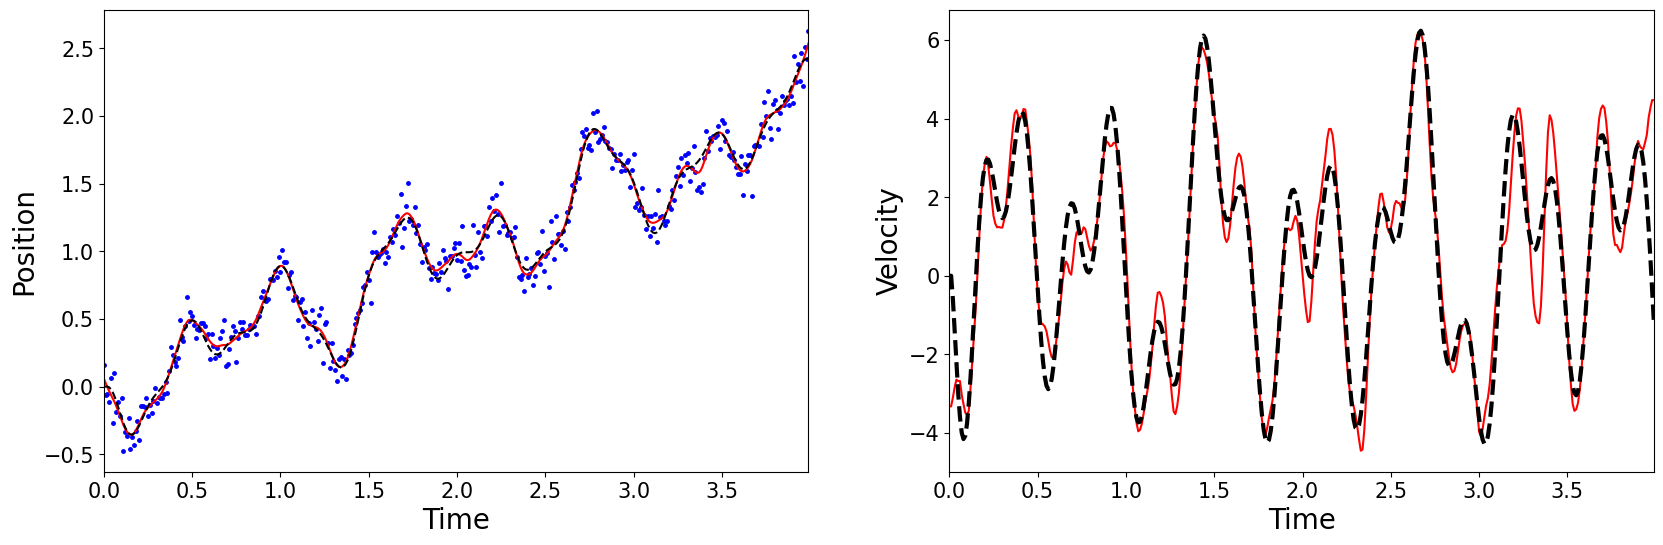

In [4]:
print('Best method:', method.__name__, 'with params:', opt_params)
x_hat, dxdt_hat = method(x, dt, **opt_params)
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth)